In [23]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
from PIL import Image
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# Structure Image Dataframe

In [ ]:
pd.read_csv()

# Normalize Images 

In [219]:
# Path to images
image_path = 'C:/Users/Zachery Key/Desktop/Forge/NeuralNet_Project/Images/'

# Path to test dataset
test_path = 'C:/Users/Zachery Key/Desktop/Forge/NeuralNet_Project/Images/data_test.csv'

# Path to train dataset 
train_path = 'C:/Users/Zachery Key/Desktop/Forge/NeuralNet_Project/Images/data_train.csv'

In [220]:
# Get a transfer dataset 
device = torch.device('cpu')
net = tv.models.resnet18(pretrained=True)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [221]:
# Load in the data
# loading dataset
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(train)
print('\n')
print(test)

     Unnamed: 0                    path  class_id  minifigure_name_x  \
0           295     marvel/0001/002.jpg         1         SPIDER-MAN   
1           300     marvel/0001/003.jpg         1         SPIDER-MAN   
2           299     marvel/0001/009.jpg         1         SPIDER-MAN   
3           298     marvel/0001/010.jpg         1         SPIDER-MAN   
4           297     marvel/0001/005.jpg         1         SPIDER-MAN   
..          ...                     ...       ...                ...   
335         182  star-wars/0015/007.jpg        36  EMPEROR PALPATINE   
336         180            test/071.jpg        36  EMPEROR PALPATINE   
337         179  star-wars/0015/005.jpg        36  EMPEROR PALPATINE   
338         184  star-wars/0015/006.jpg        36  EMPEROR PALPATINE   
339         181            test/073.jpg        36  EMPEROR PALPATINE   

                   tmp_name  minifigure_name_y  
0            1 - SPIDER-MAN         SPIDER-MAN  
1            1 - SPIDER-MAN         S

In [222]:
#Convert the csv into a torch dataset
class LEGODataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, img_size, transform=None):
        self.df = pd.read_csv(csv_file)[['path','class_id']]
        #Dropping unnecessary columns
        self.root_dir = root_dir
        #Added Image Size
        self.img_size = img_size
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        path = image_path + row['path']
        img = io.imread(path)
        img = skimage.transform.resize(img, self.img_size, anti_aliasing=True)
        #Added y to dict to showcase output labels
        #We're doing class_id - 1 because we want the output to be from 0 to N
        y = torch.tensor(row['class_id']-1, dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        sample = {'image': img, 'id_min_1': y}
        #Returns as dict
        return sample

# Normalize, rescale, and "tensorizing"   
norm_transform = tv.transforms.Compose([
                                tv.transforms.ToTensor(),
                                #VERSATILE MEAN/STD FROM IMAGENET
                                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])
                                      ])    
    
#CHANGE ACCORDINGLY (ROOTDIR)
torch_lego_train = LEGODataSet(csv_file = train_path, 
                               root_dir = image_path,
                               img_size = (256,256),
                               transform = norm_transform
                              )
torch_lego_test = LEGODataSet(csv_file = test_path, 
                              root_dir = image_path,
                              img_size = (256,256),
                              transform = norm_transform
                             )

dataloader_train = torch.utils.data.DataLoader(torch_lego_train, batch_size = 4, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(torch_lego_test, batch_size = 4, shuffle = True)

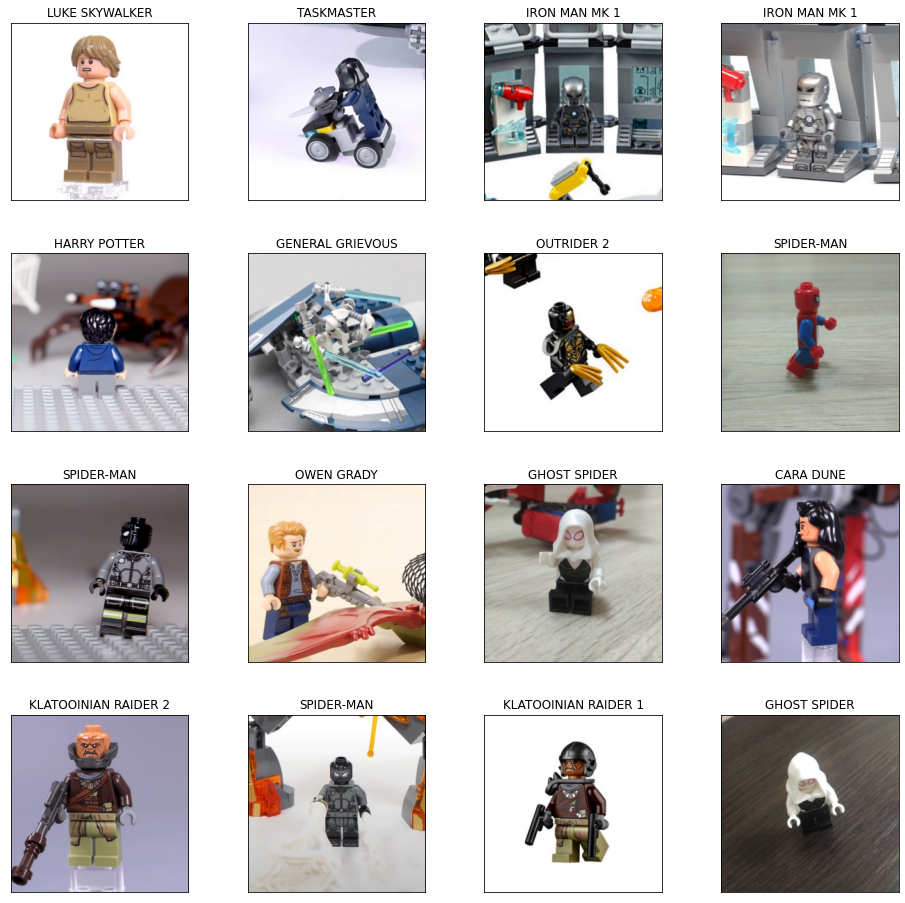

In [294]:
#For loop to normalize all train
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=.3, wspace=.3)

#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_train):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.xticks([])
        plt.yticks([])
        plt.title(id_conversion[int(ids[j].numpy())])
    if i==3:
        break

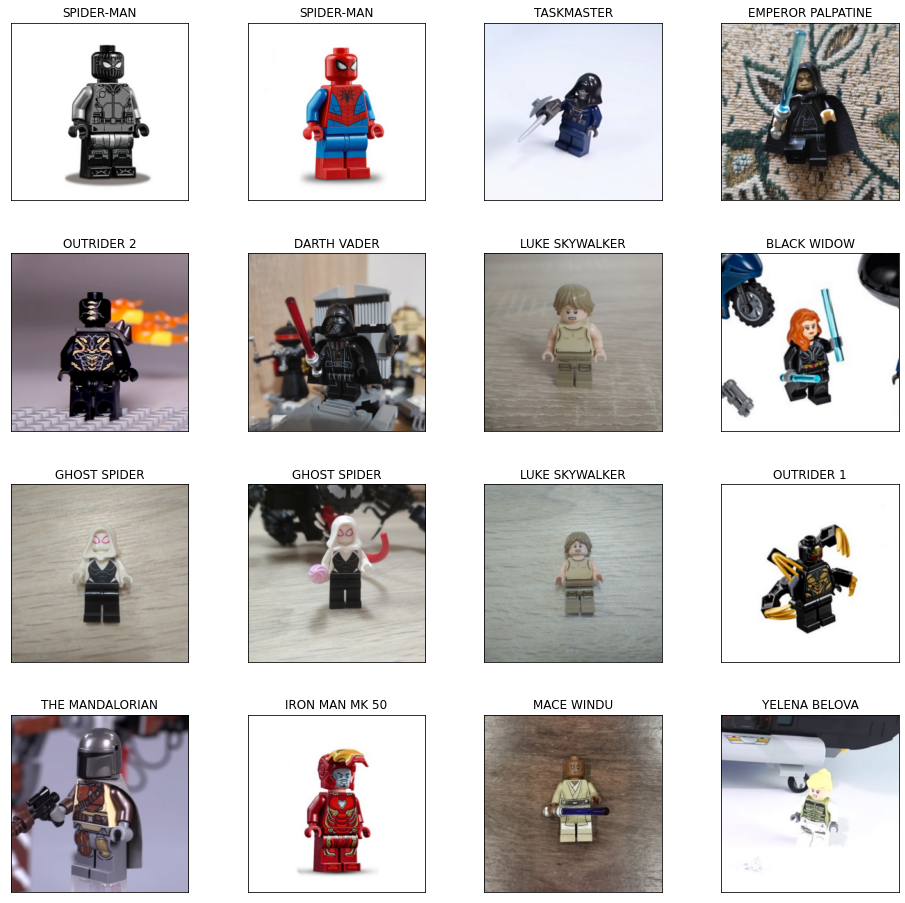

In [295]:
#For loop to normalize all test
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=.3, wspace=.3)

#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_test):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.xticks([])
        plt.yticks([])
        plt.title(id_conversion[int(ids[j].numpy())])
    if i==3:
        break

# Implement Neural Network 

In [225]:
# Hyperparameters for our Neural Network  
n_epochs = 5           # Number of runs through the model 
n_classifiers = 36     # Number of classes that we want to predict for 
momentum = 0.9         # Momentum for optimizer 
learning_rate = .005   # Learning rate for our model 

# User stuff
print_every = 10       # How often do we want to print our performance?  

In [226]:
# Define your loss function, optimizer and features 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# Define the accuracy of the model 
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

# Define the number of INPUT features in your model 
num_ftrs = net.fc.in_features

# Set the number of OUTPUT features/categories your model is classifying 
net.fc = nn.Linear(num_ftrs, n_classifiers)

In [227]:
# Initialize list to store loss and accuracy data while training the data
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
target_stuff = []

# Iterate through every training epoch 
total_step = len(dataloader_train)
for epoch in range(1, n_epochs+1):
    
    # Initialze loss variables 
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    
    # Iterate through every training batch
    for batch_idx, batch in enumerate(dataloader_train):
        
        # Plus one over here to properly match the class_ids
        data_, target_ = batch['image'].to(device), batch['id_min_1'].to(device)
        data_ = data_.float()
        
        optimizer.zero_grad()
        outputs = net(data_)
        
        # Compute the loss of the forward pass 
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        
        # Calculate the number of correct predictions vs. the total number of predictions
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        
        # Print out the epoch number, batch index, total number of steps and loss
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
            
    # Append the perfromance information to the lists to plot later
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    
    # Print out the training loss
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    
    # Record the batch loss, the number of correct 
    batch_loss = 0
    total_t = 0
    correct_t = 0
    
    # Turn requires_grad off into all of the block below. 
    # This is common practice in validation because it makes sure you have not leaked any training
    # data in your testing data AND that 
    with torch.no_grad():
        net.eval()
        
        for batch in dataloader_test:
            # Plus one over here to properly match the class_ids
            data_t, target_t = batch['image'].to(device), batch['id_min_1'].to(device)
            data_t = data_t.float()
            outputs_t = net(data_t)
            
            # Compute the loss of the 
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            
            # Pick the max probability prediction 
            _,pred_t = torch.max(outputs_t, dim=1)
            
            # Count the number of correct predictions in a batch 
            correct_t += torch.sum(pred_t==target_t).item()
            
            # Total number of predictions in a batch
            total_t += target_t.size(0)
            
        # Append the percent correct number of predictions to the accuracy list
        val_acc.append(100 * correct_t/total_t)
        
        # Append the loss value to the loss vector 
        val_loss.append(batch_loss/len(dataloader_test))
        
        # Did we improve our performance from the previous batch 
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        # Save the output of the neural network to a file when the network has improved its performance
        if network_learned:
            # Update our minimum loss if and only if the performance improved from the prior batch
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
            
    # Train the network by updating network parameters
    net.train()

Epoch 1

Epoch [1/5], Step [0/85], Loss: 3.9733
Epoch [1/5], Step [10/85], Loss: 3.5326
Epoch [1/5], Step [20/85], Loss: 2.7438
Epoch [1/5], Step [30/85], Loss: 3.2773
Epoch [1/5], Step [40/85], Loss: 3.6751
Epoch [1/5], Step [50/85], Loss: 2.8988
Epoch [1/5], Step [60/85], Loss: 2.8353
Epoch [1/5], Step [70/85], Loss: 2.8457
Epoch [1/5], Step [80/85], Loss: 2.4026

train-loss: 3.1128, train-acc: 20.0000
validation loss: 1.9718, validation acc: 60.0000

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/85], Loss: 1.8473
Epoch [2/5], Step [10/85], Loss: 1.9085
Epoch [2/5], Step [20/85], Loss: 1.8228
Epoch [2/5], Step [30/85], Loss: 1.5554
Epoch [2/5], Step [40/85], Loss: 1.7316
Epoch [2/5], Step [50/85], Loss: 1.6326
Epoch [2/5], Step [60/85], Loss: 1.3930
Epoch [2/5], Step [70/85], Loss: 1.4578
Epoch [2/5], Step [80/85], Loss: 0.9640

train-loss: 2.3779, train-acc: 76.7647
validation loss: 1.4861, validation acc: 81.1765

Improvement-Detected, save-model
Epoch 3

Epoch [3/

# Check out Model Performance

<ipython-input-288-25fe8bc4cfb9>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(image_path+'accuracy_loss.png',quality=90)


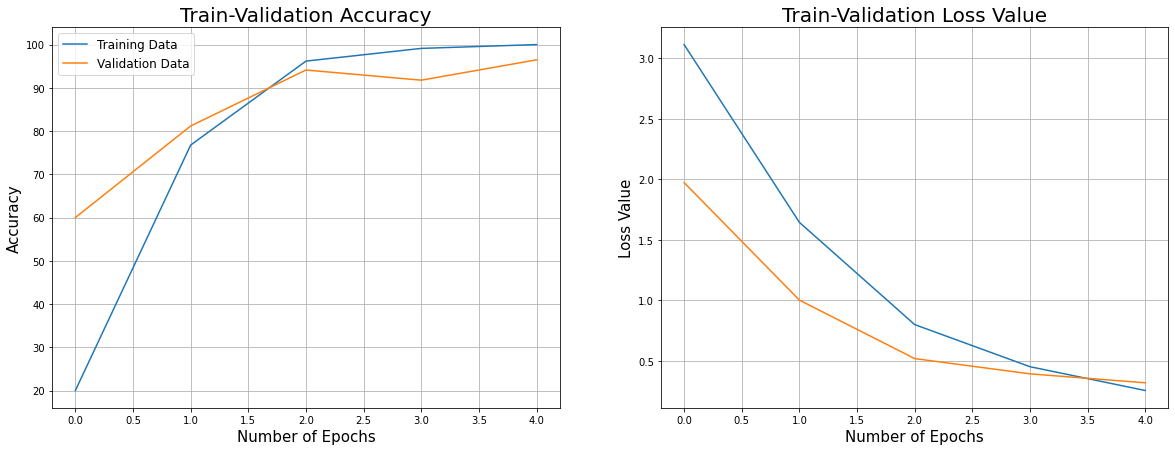

In [288]:
# Train-Validation Accuracy
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.title("Train-Validation Accuracy", fontsize=20)
plt.plot(train_acc, label='Training Data')
plt.plot(val_acc, label='Validation Data')
plt.xlabel('Number of Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(loc='best', fontsize=12)
plt.grid()

# Train-Validation Loss Value
plt.subplot(1, 2, 2)
plt.title("Train-Validation Loss Value", fontsize=20)
plt.plot(train_loss, label='Training Data')
plt.plot(val_loss, label='Validation Data')
plt.xlabel('Number of Epochs', fontsize=15)
plt.ylabel('Loss Value', fontsize=15)
plt.grid();
plt.savefig(image_path+'accuracy_loss.png',quality=90)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

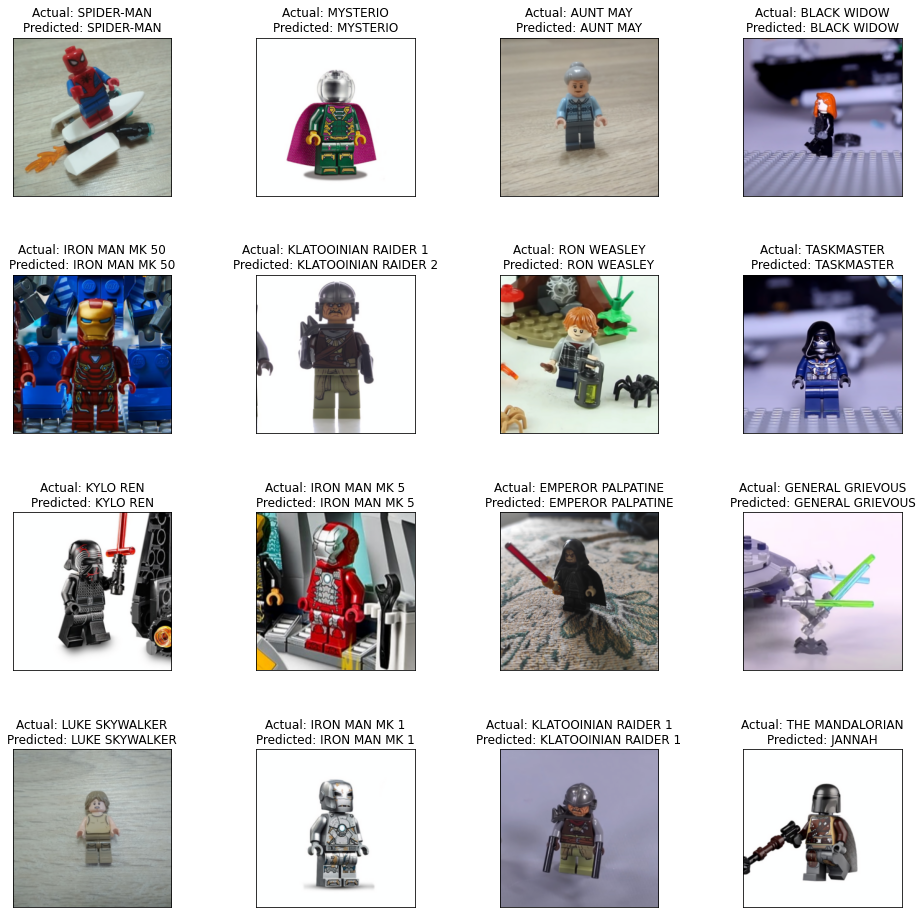

In [299]:
# Convert from ID to name of minifigure for plotting
id_conversion = test[['class_id','minifigure_name_x']].set_index('class_id').to_dict()['minifigure_name_x']

# Set up figure 
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=.5, wspace=.5)

#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_test):
    
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'].float(), batch['id_min_1']+1
    outputs = net(images)

    # Get the actual predictions 
    _, preds = torch.max(outputs.data, 1)
    preds = preds.numpy()+1
    
    for j in range(len(images)):
        # Set up the subplot image
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        predicted_label = id_conversion[int(preds[j])]
        actual_label = id_conversion[int(ids[j].numpy())]
        plt.title('Actual: '+actual_label+'\nPredicted: '+predicted_label)
        plt.xticks([])
        plt.yticks([])
        
    # Quit once the grid is full 
    if i==3:
        break

In [286]:
n_diff = str(len(set(test.minifigure_name_x).difference(set(train.minifigure_name_x))))
print('Number of differences between train and test figurines: ', n_diff)

Number of differences between train and test figurines:  0
